# Introduction to A/B Testing in R

Today, we want to analyze a fictional dataset spanning seven months from July to January, where we conducted an A/B test in October. 

The dataset is a fictional dataset which has been created in *data_creation.ipynb*

In [4]:
library(tidyverse)
# Not directly available from Workspace, locally you should be able to use install.packages("lmtest") and install.packages("sandwich")
install.packages("lmtest_0.9-40.tar.gz", repos = NULL, type = "source")
install.packages("sandwich_3.0-2.tar.gz", repos = NULL, type = "source")
#
library(lmtest)
library(sandwich)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Installing package into ‘/home/repl/renv/library/R-4.2/x86_64-pc-linux-gnu’
(as ‘lib’ is unspecified)

Installing package into ‘/home/repl/renv/library/R-4.2/x86_64-pc-linux-gnu’
(as ‘lib’ is unspecified)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




## Tasks 1

Load the **experiment_data.csv** via `read_csv` and look at some random rows.

`Month` shows the time dimension ranging from July 2022 to January 2023. 

`Group` indicates whether a customer is in the treatment group or not

`Treated` is always 0 for the control (*Existing*) group as well as for the A group before October (prior to implementing the experiment). 

`Dollars` are the $ spent by our customers 

`id` is a personal identifier of the customers



In [5]:
# Load data and look  10 random rows
customer_data <- read_csv("experiment_data.csv")
customer_data[sample(1:nrow(customer_data), size = 15), ]

Rows: 1500 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Group
dbl (4): Month, Treated, Dollars, id

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Month,Group,Treated,Dollars,id
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
202208,Existing,0,61.42,344
202211,New,1,44.88,108
202212,New,1,57.37,107
202209,Existing,0,57.68,349
202207,New,0,24.10,66
202207,Existing,0,44.29,313
202207,Existing,0,46.44,321
202209,New,0,68.57,45
202208,New,0,42.45,16


## Task 2

Look at the customer_data to see the number of customers we observe per month in each group. How many individual customers are there? 
Look at the `Treated` column by `Month`

In [9]:
cat("Rows and unique rows in the dataset:\n")
dim(customer_data)
nrow(distinct(customer_data)) # assure no duplicated rows
cat("\nUnique/distinct months in the dataset:\n")
nrow(distinct(customer_data, Month)) # Time frame
cat("\nUnique/distinct customers in the dataset:\n")
nrow(distinct(customer_data, id)) # Number of clients

cat("\nClients seeing the new and old feature:\n")
table(customer_data$Group) # Number of clients
cat("\n")
table(customer_data$Month, customer_data$Treated)

Rows and unique rows in the dataset:


[1] 1500    5

[1] 1500


Unique/distinct months in the dataset:


[1] 7


Unique/distinct customers in the dataset:


[1] 398


Clients seeing the new and old feature:



Existing      New 
     791      709 

        
           0 0.5   1
  202207 205   0   0
  202208 211   0   0
  202209 207   0   0
  202210 112  95   0
  202211 109   0 105
  202212 120   0 110
  202301 123   0 103

## Task 3 

Aggregate the whole dataset by `Month` and `Group` and look at the `Dollars` spent with a line plot. 

In [10]:
month_group_data <- customer_data %>%  group_by(Month, Group) %>%  summarize(Dollars = mean(Dollars), Treatment = mean(Treated))
month_group_data %>% arrange(Month, Group)

`summarise()` has grouped output by 'Month'. You can override using the
`.groups` argument.
New names:
• `` -> `...1`


Month,Group,Dollars,Treatment
<dbl>,<chr>,<dbl>,<dbl>
202207,Existing,52.34873,0.0
202207,New,47.11758,0.0
202208,Existing,49.44972,0.0
202208,New,47.79670,0.0
202209,Existing,48.44917,0.0
202209,New,49.57878,0.0
202210,Existing,46.25839,0.0
202210,New,49.84221,0.5
202211,Existing,49.05615,0.0


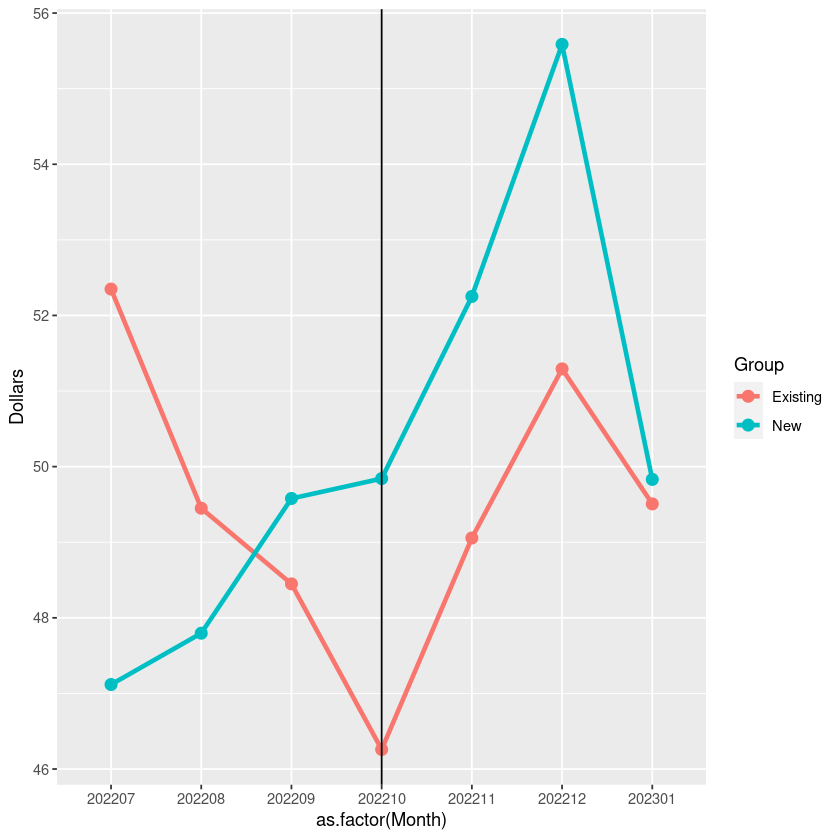

In [12]:
# Plot the time series using a line plot
time_series_plot = ggplot(month_group_data,
       aes(x = as.factor(Month),
           y = Dollars,
           color = Group,
           group = Group)) +  geom_point(size = 3) +  geom_line(linewidth = 1.3) + geom_vline(xintercept = 4) 
time_series_plot

In [13]:
# Drop October (because some in the 'New' group already saw the new product others still the old one)
customer_data = customer_data %>% filter(Month != "202210")
# Add a binary to indicate the actual A/B testing period
customer_data$AB_period = ifelse(customer_data$Month %in% c("202211", "202212", "202301"), 1, 0)
#
table(customer_data$Month, customer_data$AB_period)

        
           0   1
  202207 205   0
  202208 211   0
  202209 207   0
  202211   0 214
  202212   0 230
  202301   0 226

## Task 4

Plot the `Dollars` spent by `Group` in the actual A/B time period. 

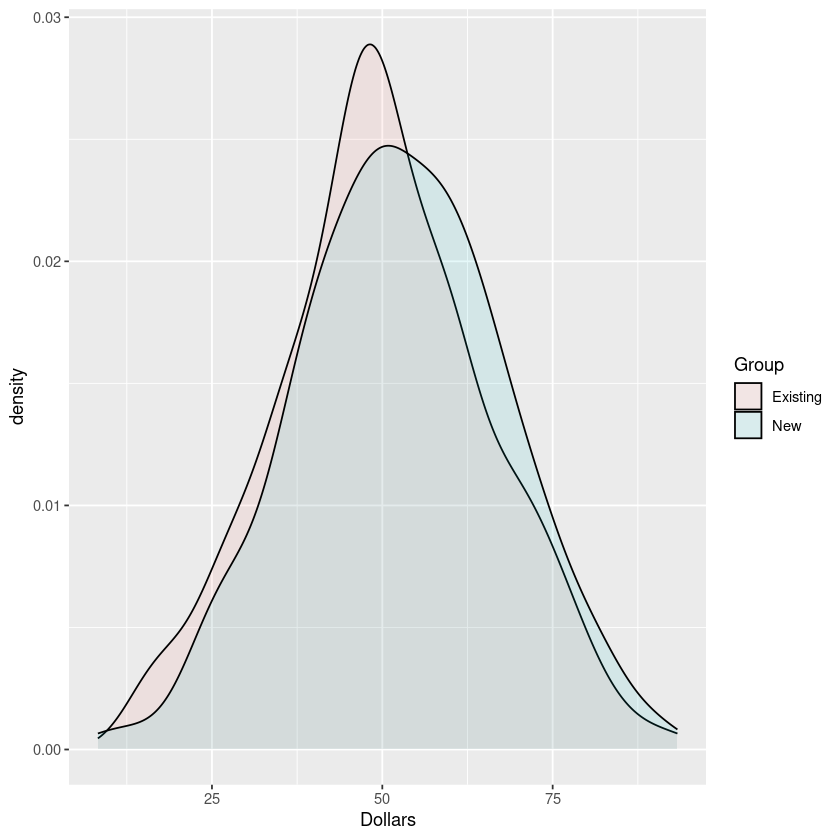

In [16]:
ggplot(customer_data %>% filter(AB_period == 1), aes(Dollars, fill = Group)) +
     geom_density(alpha = 0.1)

## Task 5 

Plot again the `Dollars` spent by `Group` in the actual A/B time period. This time, however, on a new dataset where we averaged the individual Dollars spent (by period) to avoid having multiple observations by the same customer during the same period. 

In [17]:
# Now aggregate on the customer-level that we get one row for each customer before and after seeing the "New" product
customer_data_aggregated = customer_data %>%  group_by(id, Treated, Group, AB_period) %>%  summarize(Dollars = mean(Dollars))
customer_data_aggregated = customer_data_aggregated %>% arrange(id, Treated, Group)
head(customer_data_aggregated)
tail(customer_data_aggregated)

`summarise()` has grouped output by 'id', 'Treated', 'Group'. You can override
using the `.groups` argument.
New names:
• `` -> `...1`


id,Treated,Group,AB_period,Dollars
<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,0,New,0,44.12000
1,1,New,1,56.93667
2,0,New,0,61.12000
2,1,New,1,48.73667
3,0,New,0,65.37000
3,1,New,1,53.48500


New names:
• `` -> `...1`


id,Treated,Group,AB_period,Dollars
<dbl>,<dbl>,<chr>,<dbl>,<dbl>
397,0,Existing,1,49.450
398,0,Existing,1,35.970
399,0,Existing,0,61.270
399,0,Existing,1,30.015
400,0,Existing,0,41.920
400,0,Existing,1,42.480


## Task 6

Now let's compare the `Dollars` spent between `New` vs. `Existing` `Group` in the actual A/B testing period.

In [18]:
# We can also test "New" vs "Old" after introducing "New"
t.test(
    customer_data_aggregated %>% filter(Group == "New" & AB_period == 1) %>% pull(Dollars),
    customer_data_aggregated %>% filter(Group == "Existing" & AB_period == 1) %>% pull(Dollars)
      )


	Welch Two Sample t-test

data:  customer_data_aggregated %>% filter(Group == "New" & AB_period == 1) %>% pull(Dollars) and customer_data_aggregated %>% filter(Group == "Existing" & AB_period == 1) %>% pull(Dollars)
t = 1.6855, df = 368, p-value = 0.09274
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.3656609  4.7530882
sample estimates:
mean of x mean of y 
 52.42986  50.23615 


## Task 7

But we could also compare only `New` before and after implementing the A/B test. Let's do that!! 

In [21]:
# We now can test "New" group before and after
t.test(
    customer_data_aggregated %>% filter(Group == "New" & Treated == 1) %>% pull(Dollars),
    customer_data_aggregated %>% filter(Group == "New" & Treated == 0) %>% pull(Dollars)
      )


	Welch Two Sample t-test

data:  customer_data_aggregated %>% filter(Group == "New" & Treated == 1) %>% pull(Dollars) and customer_data_aggregated %>% filter(Group == "New" & Treated == 0) %>% pull(Dollars)
t = 3.268, df = 350.19, p-value = 0.00119
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 1.818671 7.316318
sample estimates:
mean of x mean of y 
 52.42986  47.86237 


## Task 8 

Calculate the standard deviation of the `Dollars` spent in A/B period of the `New` group and use `power.t.test()` to calculate the necessary sample size to get statistical significant results on the `p = 0.05` signficiance level assuming `power = 0.8` (and equal variances). 

In [20]:
round(sd(customer_data_aggregated %>% filter(Group == "New" & AB_period == 1) %>% pull(Dollars)), 1)
power.t.test(delta = 2.2, sd = 12.4, sig.level = 0.05, power = 0.8)

[1] 12.4


     Two-sample t test power calculation 

              n = 499.6579
          delta = 2.2
             sd = 12.4
      sig.level = 0.05
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group


## Task 9

Finally, let's run a linear regression approach where we regress `Treated`, `Group`, `as.factor(Month)` on `Dollars`.
Let's correct the standard error for the fact that we observe some clients multiple times. 

In [22]:
linear_regression_approach = lm(Dollars ~ Treated + Group + as.factor(Month), data = customer_data)

In [23]:
# Wrong Standard error
summary(linear_regression_approach)


Call:
lm(formula = Dollars ~ Treated + Group + as.factor(Month), data = customer_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-46.782 -10.226  -0.544  10.124  49.115 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)             50.8064     1.2046  42.178  < 2e-16 ***
Treated                  4.5111     1.6973   2.658  0.00796 ** 
GroupNew                -1.9029     1.2216  -1.558  0.11955    
as.factor(Month)202208  -1.2347     1.4933  -0.827  0.40849    
as.factor(Month)202209  -0.9215     1.5001  -0.614  0.53912    
as.factor(Month)202211  -1.4623     1.6936  -0.863  0.38806    
as.factor(Month)202212   1.2923     1.6662   0.776  0.43811    
as.factor(Month)202301  -2.3403     1.6628  -1.407  0.15954    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 15.22 on 1285 degrees of freedom
Multiple R-squared:  0.01622,	Adjusted R-squared:  0.01086 
F-statistic: 3.027 on 7 and 1285 DF,  p-v

In [24]:
coeftest(linear_regression_approach, vcov = vcovCL, cluster = ~id)


t test of coefficients:

                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            50.80636    1.25943 40.3407  < 2e-16 ***
Treated                 4.51114    1.76617  2.5542  0.01076 *  
GroupNew               -1.90288    1.25675 -1.5141  0.13024    
as.factor(Month)202208 -1.23467    1.48177 -0.8332  0.40486    
as.factor(Month)202209 -0.92152    1.58343 -0.5820  0.56068    
as.factor(Month)202211 -1.46228    1.81296 -0.8066  0.42006    
as.factor(Month)202212  1.29234    1.82164  0.7094  0.47818    
as.factor(Month)202301 -2.34026    1.76984 -1.3223  0.18631    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
